# Classifying Iris with Keras

Original code by Nikolai Janakiev: 

https://janakiev.com/notebooks/keras-iris/

This examples uses Keras and TensorFlow to classify the same Iris dataset as the previous example (where scikit learn was used).

## Tasks

1. Try to modify this network to behave similarly to a logistic regressor
2. Add additional layers, and try out several activation functions, number of units per layer, etc.
3. Try to show not only the learing curves for the validation sets, but also for the training set.

### Imports

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard

### Data preparation

In [ ]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

The imported classes are stored as integers, but we need them in one hot encoding:

In [ ]:
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

**<font color='red'>Warning:</font>** Please never forget to normalize your data, or training will be slow or even divergent.

Here we normalize for mean 0 and std deviation 1:

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Split the data set into training and testing:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5, random_state=2)


Number of features and number of classes:

In [ ]:
n_features = X.shape[1]
n_classes = Y.shape[1]

### Visualize the data set

Two features on the left and the other two on the right.

Please check how the feature names are also loaded above in the object.

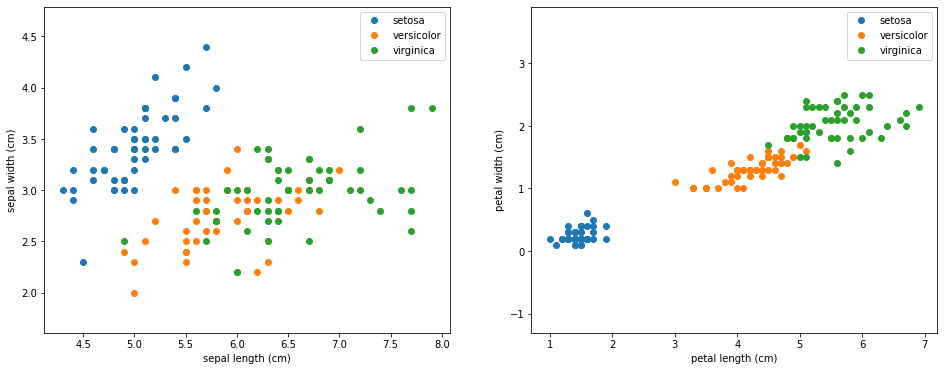

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

## Configure the neural network

The following function creates a custom model, specifying the input and output sizes (i.e. number of units), the number of nodes (or units) per hidden layer, the number of hidden layers and a name for the model.

In [ ]:
def create_custom_model(input_dim, output_dim, nodes, num_hidden_layers=1, name='model'):
    # Create model
    model = Sequential(name=name)
    for i in range(num_hidden_layers):
        model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

Create several models varying the number of hidden layers, and show their structure:

In [ ]:
models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) for i in range(1, 4)]

for model in models:
    model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 139
Trainable params: 139
Non-tr

Train all models and use TensorBoard to track the training processes

Check the tensorboard results with 

> tensorboard --logdir logs/train/


In [ ]:
!tensorboard --logdir logs/train

2021-03-24 12:59:20.526652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
W0324 12:59:21.960519 140409522956032 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0324 12:59:21.976371 140409522956032 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
## Train all three models
history_dict = {}

## TensorBoard Callback
cb = TensorBoard()

## 
for model in models:    
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.1314103752374649
Test accuracy: 0.9466666579246521
Model name: model_2
Test loss: 0.44379109144210815
Test accuracy: 0.9200000166893005
Model name: model_3
Test loss: 0.7830144166946411
Test accuracy: 0.9333333373069763


## Show results

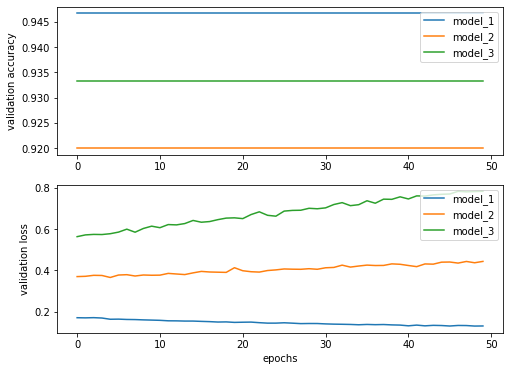

In [ ]:
## Plot accuracy and loss from training
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_acc = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_acc, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()
